# 1. Data Preparation

In [98]:
import pandas as pd

In [99]:
df = pd.read_csv('../data/processed/pdf_paragraphs.csv')
df.head()

,document,page,text,cleaned_text
0,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,purpose this article provides guidance regardi...
1,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,definitions artificial intelligence ai machine...
2,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,artificial intelligence system any system soft...
3,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,compliant artificial intelligence platform gen...
4,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,generative artificial intelligence branch of a...


In [100]:
import spacy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

def to_lemmas(text):
    if nlp is None:
        return text
    doc = nlp(text)
    return ' '.join([t.lemma_ for t in doc if t.is_alpha and len(t) >= 3])

df['cleaned_lemmas'] = df['cleaned_text'].astype(str).apply(to_lemmas)
df.head()

,document,page,text,cleaned_text,cleaned_lemmas
0,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,purpose this article provides guidance regardi...,purpose this article provide guidance regard e...
1,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,definitions artificial intelligence ai machine...,definition artificial intelligence machine bas...
2,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,artificial intelligence system any system soft...,artificial intelligence system any system soft...
3,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,compliant artificial intelligence platform gen...,compliant artificial intelligence platform gen...
4,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,generative artificial intelligence branch of a...,generative artificial intelligence branch tech...


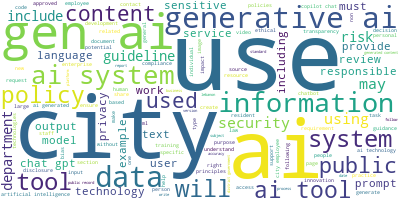

In [101]:
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['cleaned_text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [102]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

# 1) Build stopwords (toggle ACRONYMS_OPTIONAL as you prefer)
CITY_STOP = {'boston','cambridge','san','francisco','long','beach','lebanon','tempe','jose','dc','washington','district','columbia','octo','itd','tid','doit','city','county','department','division','office','agency','bureau'}
POLICY_BOILERPLATE = {'policy','policies','guidelines','principles','definitions','purpose','scope','procedures','glossary','references','contact','versioning','effective','adopted','date','chapter','section','appendix','document','documents','table','contents','page','version'}
DATES_ADMIN = {'january','february','march','april','may','june','july','august','september','october','november','december','2023','2024','2025','2026','v1','v1.1','v1.2','v1.3'}
TOOLS_VENDORS = {'copilot','microsoft','chatgpt','gemini','claude','snowflake','adobe','teams','sharepoint'}
ACRONYMS_OPTIONAL = {'22j','pra','wisp','baa','phi','pii'}  # remove from union to keep these tokens
#GENERAL_EXTRAS = {'use','using','used','users','staff','employees','tools','tool','services','work','content','information','data','generated','review','edit','ensure','include','includes','including','public','private','sensitive','confidential','approved','under','available','provide','provides','support','requirements','risk','risks','security','privacy'}

DOMAIN_STOPWORDS = CITY_STOP | POLICY_BOILERPLATE | DATES_ADMIN | TOOLS_VENDORS | ACRONYMS_OPTIONAL #| GENERAL_EXTRAS
STOPWORDS = set(ENGLISH_STOP_WORDS) | DOMAIN_STOPWORDS


In [103]:
# 2) Vectorize (bigrams + hyphen-aware tokens)
vectorizer = CountVectorizer(
    stop_words=list(STOPWORDS),
    ngram_range=(1, 2),
    max_df=0.90,
    min_df=2,
    token_pattern=r'(?u)\b[a-z][a-z\-]{2,}\b'
)
X = vectorizer.fit_transform(df['cleaned_lemmas'])
terms = vectorizer.get_feature_names_out()


# 2. LDA

In [126]:
n_topics = 10
lda = LatentDirichletAllocation(
    n_components=n_topics,
    learning_method='batch',
    max_iter=30,
    random_state=42
).fit(X)

def print_topics(model, feature_names, n_top_words=15):
    for idx, topic in enumerate(model.components_):
        top = topic.argsort()[-n_top_words:][::-1]
        print(f"Topic {idx:02d}: " + ", ".join(feature_names[i] for i in top))


print_topics(lda, terms, n_top_words=5)

Topic 00: datum, privacy, security, risk, personally
Topic 01: public, risk, requirement, officer, datum
Topic 02: transparency, public, responsible, datum, public facing
Topic 03: review, develop, principle, risk, employee
Topic 04: public, human, approve, datum, risk
Topic 05: datum, protect, regulation, law, health
Topic 06: prompt, text, resource, public, confidential
Topic 07: number, code, human, decision, review
Topic 08: ethical, responsible, standard, datum, sensitive
Topic 09: datum, data, don, opt, data collection


In [127]:
from collections import Counter
import re

def suggest_stopwords(texts, top_k=200):
    #    # crude unigram tokenizer aligned with token_pattern
    uni = Counter()
    for t in texts:
        for w in re.findall(r'[a-z][a-z\-]{2,}', t.lower()):
            uni[w] += 1
    # Return candidates that are high-frequency and uninformative by inspection
    return [w for w, c in uni.most_common(top_k)]

candidates = suggest_stopwords(df['cleaned_lemmas'], top_k=200)


In [128]:
candidates

['the',
 'and',
 'use',
 'for',
 'city',
 'that',
 'information',
 'system',
 'with',
 'you',
 'tool',
 'generative',
 'gen',
 'datum',
 'technology',
 'can',
 'this',
 'public',
 'not',
 'include',
 'policy',
 'content',
 'will',
 'these',
 'risk',
 'any',
 'from',
 'generate',
 'chat',
 'other',
 'review',
 'should',
 'provide',
 'model',
 'security',
 'human',
 'may',
 'responsible',
 'guideline',
 'your',
 'department',
 'employee',
 'when',
 'have',
 'work',
 'make',
 'prompt',
 'our',
 'such',
 'privacy',
 'user',
 'language',
 'must',
 'gpt',
 'all',
 'sensitive',
 'output',
 'they',
 'their',
 'intelligence',
 'example',
 'staff',
 'decision',
 'ensure',
 'support',
 'bias',
 'text',
 'into',
 'document',
 'service',
 'artificial',
 'impact',
 'protect',
 'training',
 'write',
 'process',
 'approve',
 'code',
 'share',
 'government',
 'access',
 'new',
 'but',
 'resource',
 'follow',
 'section',
 'learn',
 'more',
 'copilot',
 'enterprise',
 'district',
 'guidance',
 'record',


In [129]:
# --- Build stopwords ---
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

INCLUDE = {
    'the','and','for','city','use','that','information','with','you',
    'generative','gen','systems','are','tools','this','can','not',
    'content','technology','will','policy','these','any','from','used','chat',
    'should','other','may','using','your',
    'guidelines','when','system','our','such','must','gpt',
    'generated','all', 'work','department','their',
    'intelligence','including','staff','language','include','provide',
    'users','tool','have','into','artificial','example','training',
    'models','they','government','new','ensure','make','model','but',
    'services','more','copilot',
    'guidance','technologies','district','resources','outputs','uses',
    'learning','based','section','potential','while',
    'its','also','was','large', 'policies','how','about',
    'includes','non', 'related','understand',
    'machine','through','generate','shall','fact','page',
    'document','microsoft','share','following','check','which','some','people','purpose','making','request','would',
    'person','name','out','development','only','output','before',
    'protected','general','where','practices','without','contact','tasks',
    'specific','process','date','cases','what','create',
    'write','lebanon','software','limited',
    'processes','impact','usage','has',
    'does','laws','could','required','version','itd','google','within','platforms',
    'might','follow','being',"salt", "lake", "salt lake", "summary", 'guideline', 'ask'
}

STOPWORDS = set(ENGLISH_STOP_WORDS) | INCLUDE  # final stopword set

# --- Vectorizer tuned for policy text ---
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    stop_words=list(STOPWORDS),
    ngram_range=(1, 3),                 # keep bigrams (e.g., "public records", "data protection")
    max_df=0.90,                        # mute ultra-common terms across corpus
    min_df=2,                            # require term appears in >= 2 docs/pages
    token_pattern=r'(?u)\b[a-z][a-z\-]{2,}\b'  # >=3 chars, allows hyphenated tokens
)

X = vectorizer.fit_transform(df['cleaned_lemmas'])
terms = vectorizer.get_feature_names_out()

print("Vocab size:", len(terms))
print("Sample terms:", terms[:30])


Vocab size: 1951
Sample terms: ['ability' 'ability age' 'ability age religious' 'ability learn' 'able'
 'abstract' 'abstract perception' 'abstract perception analysis'
 'acceptable' 'access' 'access code' 'access code personal'
 'access disclosure' 'access financial' 'access financial account'
 'access public' 'accessibility' 'accessible' 'accordance'
 'accordance applicable' 'accordance applicable law' 'accordance security'
 'account' 'account electronic' 'account electronic mail' 'account number'
 'account number credit' 'account obtain' 'account obtain publicly'
 'accountability']


In [130]:
n_topics = 8  # start 8–15 for policy corpora; tune based on coherence
lda = LatentDirichletAllocation(
    n_components=n_topics,
    learning_method='batch',
    max_iter=30,
    random_state=42
).fit(X)


print_topics(lda, terms, n_top_words=5)

Topic 00: human, datum, responsibility, public, employee
Topic 01: review, number, public, code, access
Topic 02: prompt, user, employee, task, image
Topic 03: review, responsible, privacy, datum, source
Topic 04: public, datum, sensitive, prompt, risk
Topic 05: datum, user, platform, resource, service
Topic 06: public, datum, approve, requirement, consumer
Topic 07: datum, principle, protect, personally, ethical


In [131]:
from gensim import corpora
from gensim.utils import simple_preprocess

texts = [simple_preprocess(t) for t in df['cleaned_lemmas']]
gensim_dictionary = corpora.Dictionary(texts)
gensim_dictionary.filter_extremes(no_below=5, no_above=0.5)
gensim_corpus = [gensim_dictionary.doc2bow(t) for t in texts]
print(f"Dictionary size after filtering: {len(gensim_dictionary)} tokens")
print(f"Corpus docs: {len(gensim_corpus)}")

Dictionary size after filtering: 536 tokens
Corpus docs: 877


In [132]:
# from gensim import corpora, models
# from gensim.models import CoherenceModel
# import numpy as np
# import matplotlib.pyplot as plt

# # Create gensim dictionary and corpus
# dictionary = corpora.Dictionary()
# dictionary.id2token = {i: term for i, term in enumerate(terms)}
# dictionary.token2id = {term: i for i, term in enumerate(terms)}

# # Convert sparse X to list of tuples (word_id, freq) for each doc
# corpus = []
# for doc_idx in range(X.shape[0]):
#     doc = []
#     for word_idx, freq in zip(X[doc_idx].indices, X[doc_idx].data):
#         doc.append((word_idx, int(freq)))
#     corpus.append(doc)

# # Test different topic numbers using perplexity (lower is better)
# topic_range = range(3, 16) 
# perplexity_scores = []
# models_list = []

# print("Computing scores...")
# for n_topics in topic_range:
#     print(f"  n_topics={n_topics}...", end=" ")
#     lda_temp = LatentDirichletAllocation(
#         n_components=n_topics,
#         learning_method='batch',
#         max_iter=30,
#         random_state=42
#     ).fit(X)
    
#     perplexity = lda_temp.perplexity(X)
#     perplexity_scores.append(perplexity)
#     models_list.append(lda_temp)
#     print(f"perplexity={perplexity:.4f}")

# # Find optimal number of topics (lowest perplexity)
# best_idx = np.argmin(perplexity_scores)
# optimal_n_topics = list(topic_range)[best_idx]
# best_perplexity = perplexity_scores[best_idx]

# print(f"\nOptimal number of topics: {optimal_n_topics} (perplexity={best_perplexity:.4f})")

# # Plot perplexity scores
# plt.figure(figsize=(10, 6))
# plt.plot(list(topic_range), perplexity_scores, marker='o', color='steelblue')
# plt.xlabel('Number of Topics')
# plt.ylabel('Perplexity (lower is better)')
# plt.title('LDA Perplexity by Number of Topics')
# plt.axvline(x=optimal_n_topics, color='r', linestyle='--', label=f'Optimal: {optimal_n_topics}')
# plt.legend()
# plt.grid()
# plt.show()

# # Use the best model
# lda = models_list[best_idx]
# print(f"\nUsing LDA with {optimal_n_topics} topics:")
# print_topics(lda, terms, n_top_words=10)

In [133]:
optimal_n_topics = 5
optimal_n_topics

5

# 3. Vizualization

In [135]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import os

# Build gensim LDA model from scratch (required for pyLDAvis)
gensim_dictionary = corpora.Dictionary()
gensim_dictionary.id2token = {i: term for i, term in enumerate(terms)}
gensim_dictionary.token2id = {term: i for i, term in enumerate(terms)}

# Convert to gensim corpus format
gensim_corpus = []
for doc_idx in range(X.shape[0]):
    doc = []
    for word_idx, freq in zip(X[doc_idx].indices, X[doc_idx].data):
        doc.append((word_idx, int(freq)))
    gensim_corpus.append(doc)

print(f"Training Gensim LDA with {optimal_n_topics} topics for visualization...")
gensim_lda = models.LdaMulticore(
    corpus=gensim_corpus,
    id2word=gensim_dictionary,
    num_topics=optimal_n_topics,
    workers=2,
    #passes=30,
    per_word_topics=True,
    random_state=42,
    iterations=100,
    alpha='asymmetric',
    eta='auto'
)

vis = gensimvis.prepare(gensim_lda, gensim_corpus, gensim_dictionary,sort_topics=False)

# Save interactive HTML
output_path = '../visualizations/lda_interactive.html'
os.makedirs('../visualizations', exist_ok=True)
pyLDAvis.save_html(vis, output_path)

vis

Training Gensim LDA with 5 topics for visualization...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.018739  0.026432       1        1  48.831872
1      0.117137  0.028420       2        1  18.432738
2     -0.047168 -0.041281       3        1  13.044949
3     -0.056187  0.077090       4        1   9.835522
4      0.004957 -0.090661       5        1   9.854918, topic_info=            Term       Freq      Total Category  logprob  loglift
1575      review  50.000000  50.000000  Default  30.0000  30.0000
1388      prompt  38.000000  38.000000  Default  29.0000  29.0000
454        datum  95.000000  95.000000  Default  28.0000  28.0000
1359     privacy  37.000000  37.000000  Default  27.0000  27.0000
1179      number  17.000000  17.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
1668   sensitive   3.028756  33.418817   Topic5  -5.6361  -0.0838
1795        team   2.867273  19.658119   Topic5  -5

In [137]:
# print five topic 
for idx, topic in enumerate(gensim_lda.print_topics(num_words=5)):
    print(f"Topic {idx + 1}: {topic[1]}")

Topic 1: 0.016*"datum" + 0.012*"public" + 0.008*"human" + 0.007*"risk" + 0.006*"responsible"
Topic 2: 0.015*"review" + 0.012*"public" + 0.009*"risk" + 0.007*"number" + 0.006*"security"
Topic 3: 0.010*"prompt" + 0.009*"datum" + 0.009*"employee" + 0.007*"decision" + 0.007*"text"
Topic 4: 0.009*"datum" + 0.007*"resource" + 0.006*"review" + 0.006*"bias" + 0.005*"protect"
Topic 5: 0.009*"privacy" + 0.007*"datum" + 0.007*"risk" + 0.007*"description" + 0.006*"public"


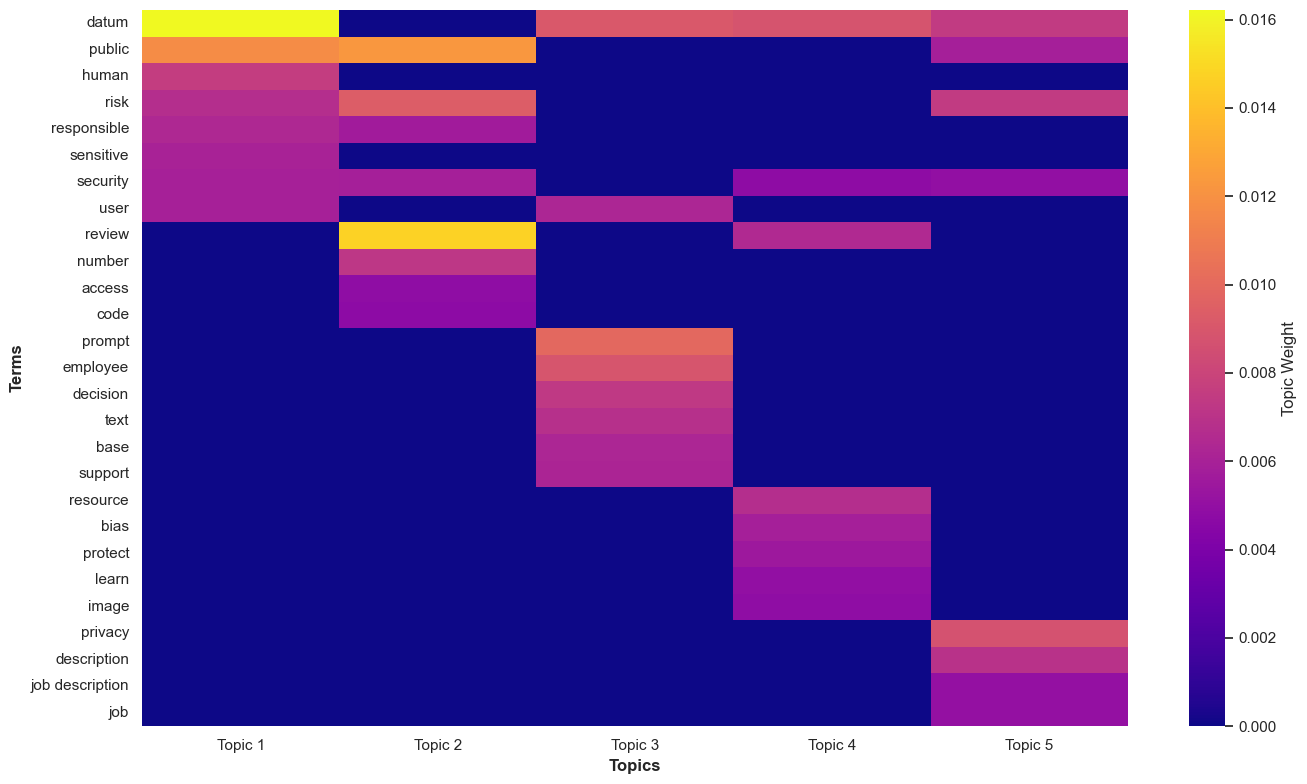

In [ ]:
import seaborn as sns

sns.set_theme()

fig, axes = plt.subplots(figsize=(14, 8))

# Extract top 8 terms per topic from gensim model
topics_terms = {} 
for idx in range(optimal_n_topics):
    terms_dist = gensim_lda.show_topic(idx, topn=8)
    topics_terms[f'Topic {idx + 1}'] = {term: float(prob) for term, prob in terms_dist}

# Create heatmap data
heatmap_df = pd.DataFrame(topics_terms).fillna(0)

sns.heatmap(heatmap_df, 
            cmap='plasma',
            cbar_kws={'label': 'Topic Weight'}, 
            ax=axes)

axes.set_xlabel('Topics', fontsize=12, fontweight='bold')
axes.set_ylabel('Terms', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../visualizations/topic_terms_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


In [139]:
if getattr(lda, "n_components", None) != optimal_n_topics:
    lda = LatentDirichletAllocation(
        n_components=optimal_n_topics,
        learning_method='batch',
        max_iter=30,
        random_state=42
    ).fit(X)

doc_topic_dist = lda.transform(X)  # shape: (n_documents, n_topics)

df_with_topics = df.copy()
df_with_topics['document'] = df_with_topics['document'].str.strip('.pdf')
df_with_topics['doc_id'] = range(len(df))

# Add topic distribution for each paragraph
for topic_idx in range(optimal_n_topics):
    df_with_topics[f'topic_{topic_idx}_prob'] = doc_topic_dist[:, topic_idx]

# Aggregate by document: average topic distribution per document
doc_topic_agg = df_with_topics.groupby('document')[[f'topic_{i}_prob' for i in range(optimal_n_topics)]].mean()
doc_topic_agg.columns = [f'Topic {i +1}' for i in range(optimal_n_topics)]

print("Document-Topic Distribution (Aggregated):")
print(doc_topic_agg)
print(f"\nShape: {doc_topic_agg.shape} (documents × topics)")

Document-Topic Distribution (Aggregated):
               Topic 1   Topic 2   Topic 3   Topic 4   Topic 5
document                                                      
Boston        0.247660  0.148394  0.246029  0.167174  0.190743
Cambridge     0.206347  0.152459  0.212858  0.189268  0.239068
DC            0.203891  0.158247  0.125585  0.295605  0.216673
Lebanon       0.279767  0.198560  0.266900  0.121132  0.133641
LongBeach     0.207712  0.177594  0.179018  0.225054  0.210622
SF            0.246082  0.151798  0.209212  0.179871  0.213036
SaltLakeCity  0.202809  0.158705  0.253914  0.225879  0.158693
SanJose       0.287223  0.136637  0.139376  0.270980  0.165784
Tempe         0.389677  0.196216  0.139989  0.176204  0.097914

Shape: (9, 5) (documents × topics)


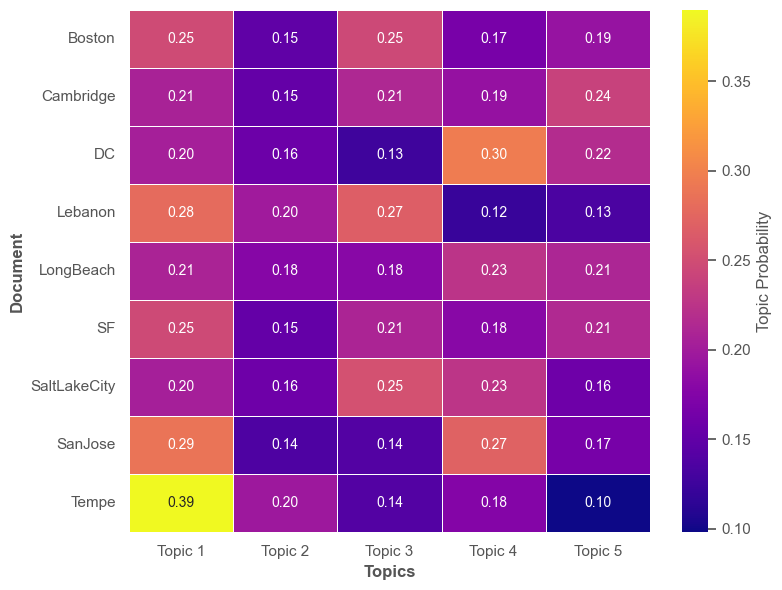

In [172]:
# Shows topic composition for each document
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 6))

# Normalize for heatmap (0-1 scale)
sns.heatmap(
    doc_topic_agg,
    cmap='plasma',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Topic Probability'},
    linewidths=0.5,
    ax=ax
)
#ax.set_title('Topic Distribution Across Documents', fontsize=14, fontweight='bold')
ax.set_xlabel('Topics', fontsize=12, fontweight='bold')
ax.set_ylabel('Document', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../visualizations/doc_topic_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

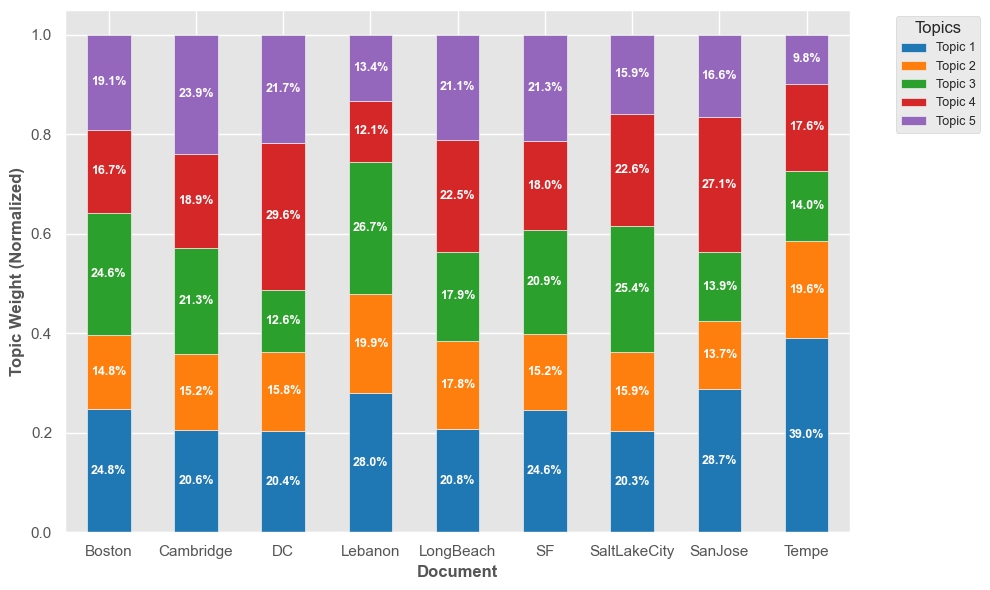

In [174]:
# Shows relative topic composition per document (normalized)

from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(10, 6))

# Normalize rows to sum to 1 for stacked bar chart
doc_topic_normalized = doc_topic_agg.div(doc_topic_agg.sum(axis=1), axis=0)

# Build palette using the first 6 tab10 colors (blue through brown)
base_colors = plt.get_cmap('tab10').colors[:6]
palette = (list(base_colors) * ((optimal_n_topics + 5) // 6))[:optimal_n_topics]

doc_topic_normalized.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    colormap=ListedColormap(palette),
)

# Add percentages inside bars
for i, doc in enumerate(doc_topic_normalized.index):
    cumsum = 0
    for j, topic in enumerate(doc_topic_normalized.columns):
        value = doc_topic_normalized.iloc[i, j]
        if value > 0.05:  # Only show percentage if bar segment is large enoughS
            ax.text(i, cumsum + value/2, f'{value*100:.1f}%', 
                   ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        cumsum += value

ax.set_xlabel('Document', fontsize=12, fontweight='bold')
ax.set_ylabel('Topic Weight (Normalized)', fontsize=12, fontweight='bold')

ax.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../visualizations/doc_topic_stacked.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/lf/1r0cw2qs3pq870f2x7yb20w40000gn/T/ipykernel_36812/898896628.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  doc_colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(doc_topic_agg)))


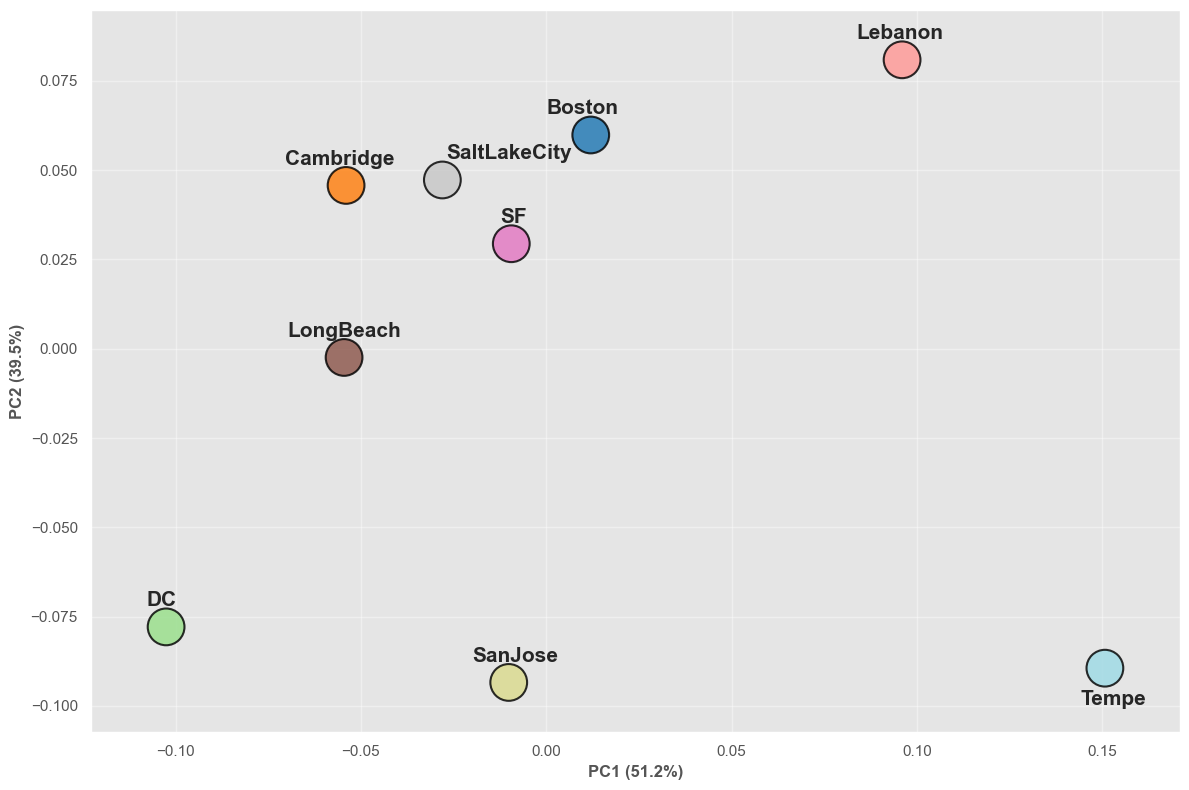

In [182]:
# Visualize documents in 2D space based on topic similarity

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Compute document similarity using cosine distance on topic distributions
doc_similarity = cosine_similarity(doc_topic_agg)

# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
doc_topic_2d = pca.fit_transform(doc_topic_agg)

# Build non-repeating colors across documents (tab20 sampled uniquely)
doc_colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(doc_topic_agg)))

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    doc_topic_2d[:, 0],
    doc_topic_2d[:, 1],
    s=700,
    alpha=0.82,
    color=doc_colors,
    edgecolors='black',
    linewidth=1.5
)

ax.margins(0.08)
jitters = np.linspace(-6, 6, len(doc_topic_agg))  # symmetric horizontal offsets
for idx, doc_name in enumerate(doc_topic_agg.index):
    name_lower = doc_name.lower()
    is_tempe = name_lower.startswith('tempe')
    is_salt_lake = name_lower.startswith('salt')

    if is_salt_lake:
       #offset_y = 0
        va_align = 'bottom'
        ha_align = 'left'
        x_offset = jitters[idx]
    else:
        offset_y = -16 if is_tempe else 12
        va_align = 'top' if is_tempe else 'bottom'
        ha_align = 'center'
        x_offset = jitters[idx]

    ax.annotate(
        doc_name,
        (doc_topic_2d[idx, 0], doc_topic_2d[idx, 1]),
        xytext=(x_offset, offset_y),
        textcoords='offset points',
        ha=ha_align,
        va=va_align,
        fontsize=15,
        fontweight='bold',
        clip_on=True
)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12, fontweight='bold')
ax.grid(alpha=0.4)
plt.tight_layout()

plt.savefig('../visualizations/doc_similarity_pca.png', dpi=300, bbox_inches='tight')

plt.show()

In [120]:
doc_topic_agg

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
document,,,,,
Boston,0.223714,0.215043,0.147856,0.211758,0.201630
Cambridge,0.170085,0.194703,0.175703,0.206785,0.252724
DC,0.256726,0.203779,0.190275,0.233497,0.115724
Lebanon,0.158830,0.213590,0.251895,0.163914,0.211771
LongBeach,0.173993,0.182950,0.200128,0.254674,0.188254
SF,0.178984,0.154660,0.186551,0.218198,0.261607
SaltLakeCity,0.064811,0.317073,0.272195,0.143908,0.202012
SanJose,0.123220,0.143125,0.182109,0.371086,0.180460
Tempe,0.176132,0.162731,0.218706,0.220000,0.222430


In [ ]:
# Extract detailed information about each topic

print("=" * 80)
print("TOPIC ANALYSIS SUMMARY")
print("=" * 80)

topic_summary = []
for topic_id in range(optimal_n_topics):
    # Get top terms and their probabilities
    top_terms = gensim_lda.show_topic(topic_id, topn=10)
    terms_list = [term for term, prob in top_terms]
    probs_list = [prob for term, prob in top_terms]
    
    # Get average topic prevalence across documents
    avg_prevalence = doc_topic_agg[f'Topic {topic_id + 1}'].mean()
    max_prevalence = doc_topic_agg[f'Topic {topic_id + 1}'].max()
    
    # Count how many documents have this as dominant topic
    dominant_count = (doc_topic_agg[f'Topic {topic_id + 1}'] == doc_topic_agg.max(axis=1)).sum()
    
    print(f"\n{'─' * 80}")
    print(f"TOPIC {topic_id + 1}")
    print(f"{'─' * 80}")
    print(f"  Top Keywords (ranked by relevance):")
    for i, (term, prob) in enumerate(top_terms[:5], 1):
        print(f"    {i}. {term:20s} (weight: {prob:.4f})")
    
    print(f"\n  Statistics:")
    print(f"    • Average prevalence across documents: {avg_prevalence:.4f}")
    print(f"    • Max prevalence in any document:     {max_prevalence:.4f}")
    print(f"    • Dominant in {dominant_count}/{len(doc_topic_agg)} documents")
    print(f"    • Total unique keywords:              {len(terms_list)}")
    
    topic_summary.append({
        'Topic': topic_id + 1,
        'Top_Keywords': ', '.join(terms_list[:5]),
        'Avg_Prevalence': avg_prevalence,
        'Max_Prevalence': max_prevalence,
        'Dominant_Count': dominant_count,
        'Unique_Keywords': len(terms_list)
    })

print(f"\n{'=' * 80}\n")
topic_summary_df = pd.DataFrame(topic_summary)
print("QUICK REFERENCE TABLE:")
print(topic_summary_df.to_string(index=False))

TOPIC ANALYSIS SUMMARY

────────────────────────────────────────────────────────────────────────────────
TOPIC 1
────────────────────────────────────────────────────────────────────────────────
  Top Keywords (ranked by relevance):
    1. datum                (weight: 0.0125)
    2. security             (weight: 0.0089)
    3. responsible          (weight: 0.0076)
    4. risk                 (weight: 0.0071)
    5. prompt               (weight: 0.0069)

  Statistics:
    • Average prevalence across documents: 0.1696
    • Max prevalence in any document:     0.2567
    • Dominant in 2/9 documents
    • Total unique keywords:              10

────────────────────────────────────────────────────────────────────────────────
TOPIC 2
────────────────────────────────────────────────────────────────────────────────
  Top Keywords (ranked by relevance):
    1. public               (weight: 0.0164)
    2. datum                (weight: 0.0080)
    3. security             (weight: 0.0058)
    4. r


TOP 30 KEYWORDS ACROSS ALL TOPICS
 1. datum                     | Weight: 0.0556
 2. public                    | Weight: 0.0425
 3. risk                      | Weight: 0.0327
 4. review                    | Weight: 0.0280
 5. human                     | Weight: 0.0238
 6. security                  | Weight: 0.0234
 7. employee                  | Weight: 0.0209
 8. responsible               | Weight: 0.0197
 9. user                      | Weight: 0.0166
10. privacy                   | Weight: 0.0164
11. prompt                    | Weight: 0.0133
12. sensitive                 | Weight: 0.0108
13. support                   | Weight: 0.0108
14. decision                  | Weight: 0.0101
15. bias                      | Weight: 0.0101
16. code                      | Weight: 0.0095
17. confidential              | Weight: 0.0095
18. help                      | Weight: 0.0087
19. enterprise                | Weight: 0.0086
20. text                      | Weight: 0.0086
21. transparency         

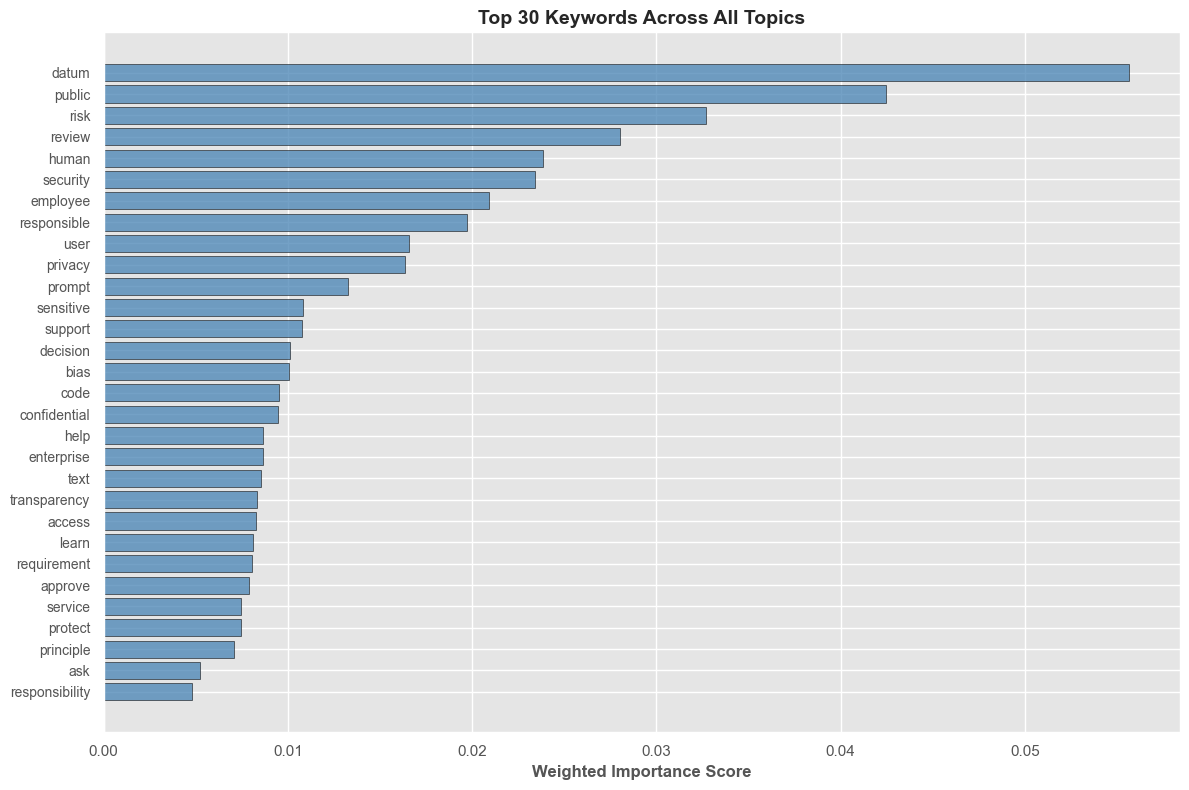

In [ ]:
# Identify most important keywords across all topics

all_terms_weighted = {}
for topic_id in range(optimal_n_topics):
    top_terms = gensim_lda.show_topic(topic_id, topn=20)
    for term, prob in top_terms:
        if term not in all_terms_weighted:
            all_terms_weighted[term] = 0
        all_terms_weighted[term] += prob

# Sort by weighted frequency
sorted_terms = sorted(all_terms_weighted.items(), key=lambda x: x[1], reverse=True)
top_30_terms = sorted_terms[:30]

print("\n" + "=" * 80)
print("TOP 30 KEYWORDS ACROSS ALL TOPICS")
print("=" * 80)
for rank, (term, weight) in enumerate(top_30_terms, 1):
    print(f"{rank:2d}. {term:25s} | Weight: {weight:.4f}")

# Visualize top keywords
fig, ax = plt.subplots(figsize=(12, 8))
terms_plot = [t[0] for t in top_30_terms]
weights_plot = [t[1] for t in top_30_terms]

bars = ax.barh(range(len(terms_plot)), weights_plot, color='steelblue', alpha=0.75, edgecolor='black')
ax.set_yticks(range(len(terms_plot)))
ax.set_yticklabels(terms_plot, fontsize=10)
ax.set_xlabel('Weighted Importance Score', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Keywords Across All Topics', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../visualizations/top_keywords_global.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Show which keywords are most tied to specific topics (vs shared across topics)

print("\n" + "=" * 80)
print("TOPIC SPECIALIZATION ANALYSIS")
print("=" * 80)

term_specialization = []
for topic_id in range(optimal_n_topics):
    top_terms = gensim_lda.show_topic(topic_id, topn=8)
    
    print(f"\nTopic {topic_id + 1} - Signature Keywords:")
    for i, (term, prob) in enumerate(top_terms, 1):
        # Calculate how much this term belongs to this topic vs others
        term_topics = []
        for tid in range(optimal_n_topics):
            ttopics = dict(gensim_lda.show_topic(tid, topn=100))
            if term in ttopics:
                term_topics.append(ttopics[term])
            else:
                term_topics.append(0)
        
        max_prob_other = max(term_topics[:topic_id] + term_topics[topic_id+1:])
        specificity = prob / (max(prob, max_prob_other) + 1e-10)
        
        print(f"  {i}. {term:20s} | Weight: {prob:.4f} | Specificity: {specificity:.2f}")
        term_specialization.append({
            'Topic': topic_id + 1,
            'Term': term,
            'Weight': prob,
            'Specificity': specificity
        })


TOPIC SPECIALIZATION ANALYSIS

Topic 1 - Signature Keywords:
  1. datum                | Weight: 0.0125 | Specificity: 0.88
  2. security             | Weight: 0.0089 | Specificity: 1.00
  3. responsible          | Weight: 0.0076 | Specificity: 1.00
  4. risk                 | Weight: 0.0071 | Specificity: 0.82
  5. prompt               | Weight: 0.0069 | Specificity: 1.00
  6. privacy              | Weight: 0.0069 | Specificity: 1.00
  7. confidential         | Weight: 0.0057 | Specificity: 1.00
  8. ask                  | Weight: 0.0053 | Specificity: 1.00

Topic 2 - Signature Keywords:
  1. public               | Weight: 0.0164 | Specificity: 1.00
  2. datum                | Weight: 0.0080 | Specificity: 0.57
  3. security             | Weight: 0.0058 | Specificity: 0.65
  4. risk                 | Weight: 0.0056 | Specificity: 0.65
  5. review               | Weight: 0.0054 | Specificity: 0.64
  6. access               | Weight: 0.0046 | Specificity: 1.00
  7. decision            


DOCUMENT-LEVEL TOPIC COVERAGE

Boston
  • Primary topic: Topic 1 (22.37%)
  • Topic diversity (entropy): 1.600
  • Significant topics (>10%): 5

Cambridge
  • Primary topic: Topic 5 (25.27%)
  • Topic diversity (entropy): 1.599
  • Significant topics (>10%): 5

DC
  • Primary topic: Topic 1 (25.67%)
  • Topic diversity (entropy): 1.578
  • Significant topics (>10%): 5

Lebanon
  • Primary topic: Topic 3 (25.19%)
  • Topic diversity (entropy): 1.594
  • Significant topics (>10%): 5

LongBeach
  • Primary topic: Topic 4 (25.47%)
  • Topic diversity (entropy): 1.600
  • Significant topics (>10%): 5

SF
  • Primary topic: Topic 5 (26.16%)
  • Topic diversity (entropy): 1.593
  • Significant topics (>10%): 5

SaltLakeCity
  • Primary topic: Topic 2 (31.71%)
  • Topic diversity (entropy): 1.498
  • Significant topics (>10%): 4

SanJose
  • Primary topic: Topic 4 (37.11%)
  • Topic diversity (entropy): 1.523
  • Significant topics (>10%): 5

Tempe
  • Primary topic: Topic 5 (22.24%)
  • Topi

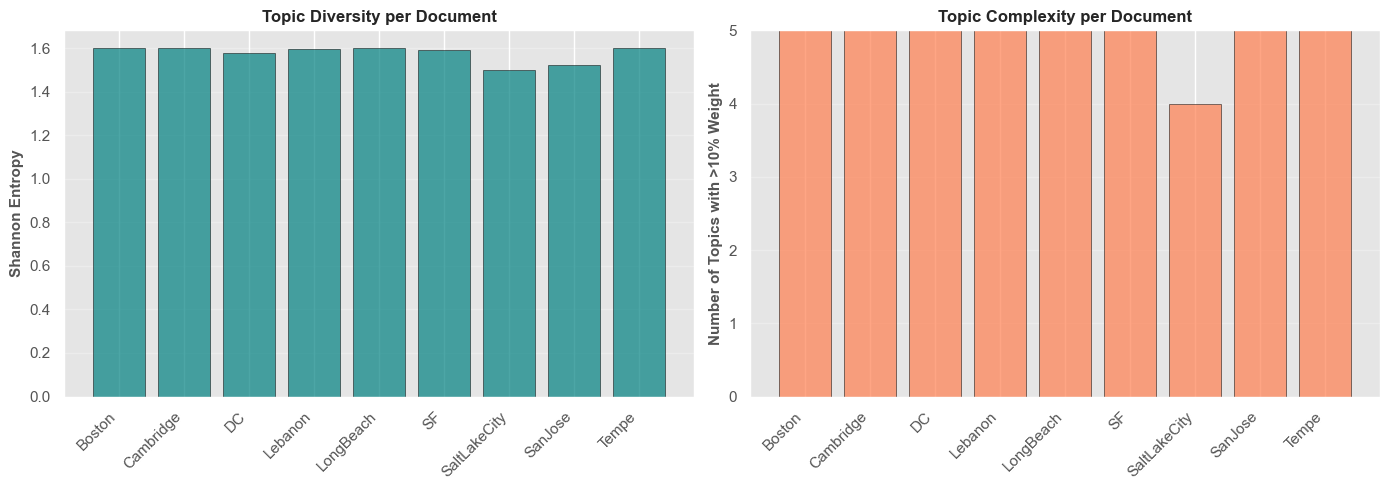


GLOBAL TOPIC BALANCE

Average topic prevalence across all documents:
  Topic 1: 0.1696 (16.96%)
  Topic 2: 0.1986 (19.86%)
  Topic 3: 0.2028 (20.28%)
  Topic 4: 0.2249 (22.49%)
  Topic 5: 0.2041 (20.41%)

Topic balance (std dev): 0.0198
  → Lower std dev = more balanced topics
  → Higher std dev = some topics dominate


In [ ]:
# Analyze how well documents are covered and if topics are balanced

print("\n" + "=" * 80)
print("DOCUMENT-LEVEL TOPIC COVERAGE")
print("=" * 80)

coverage_stats = []
for doc_idx, doc_name in enumerate(doc_topic_agg.index):
    doc_probs = doc_topic_agg.iloc[doc_idx].values
    
    # Calculate metrics
    top_topic_prob = doc_probs.max()
    top_topic_num = np.argmax(doc_probs) + 1
    entropy = -np.sum([p * np.log(p + 1e-10) for p in doc_probs])  # Shannon entropy
    num_significant_topics = (doc_probs > 0.1).sum()  # Topics with >10% weight
    
    coverage_stats.append({
        'Document': doc_name,
        'Primary_Topic': top_topic_num,
        'Primary_Weight': top_topic_prob,
        'Entropy': entropy,
        'Significant_Topics': num_significant_topics
    })
    
    print(f"\n{doc_name}")
    print(f"  • Primary topic: Topic {top_topic_num} ({top_topic_prob:.2%})")
    print(f"  • Topic diversity (entropy): {entropy:.3f}")
    print(f"  • Significant topics (>10%): {num_significant_topics}")

coverage_df = pd.DataFrame(coverage_stats)

# Visualization: Document entropy distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Entropy distribution
ax1.bar(range(len(coverage_df)), coverage_df['Entropy'], color='teal', alpha=0.7, edgecolor='black')
ax1.set_xticks(range(len(coverage_df)))
ax1.set_xticklabels(coverage_df['Document'], rotation=45, ha='right')
ax1.set_ylabel('Shannon Entropy', fontsize=11, fontweight='bold')
ax1.set_title('Topic Diversity per Document', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Significant topics per document
ax2.bar(range(len(coverage_df)), coverage_df['Significant_Topics'], color='coral', alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(coverage_df)))
ax2.set_xticklabels(coverage_df['Document'], rotation=45, ha='right')
ax2.set_ylabel('Number of Topics with >10% Weight', fontsize=11, fontweight='bold')
ax2.set_title('Topic Complexity per Document', fontsize=12, fontweight='bold')
ax2.set_ylim([0, optimal_n_topics])
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/document_coverage.png', dpi=300, bbox_inches='tight')
plt.show()

# Global topic balance
print("\n" + "=" * 80)
print("GLOBAL TOPIC BALANCE")
print("=" * 80)
topic_sizes = doc_topic_agg.mean()
print(f"\nAverage topic prevalence across all documents:")
for topic_id, prevalence in enumerate(topic_sizes, 1):
    print(f"  Topic {topic_id}: {prevalence:.4f} ({prevalence*100:.2f}%)")

print(f"\nTopic balance (std dev): {topic_sizes.std():.4f}")
print(f"  → Lower std dev = more balanced topics")
print(f"  → Higher std dev = some topics dominate")

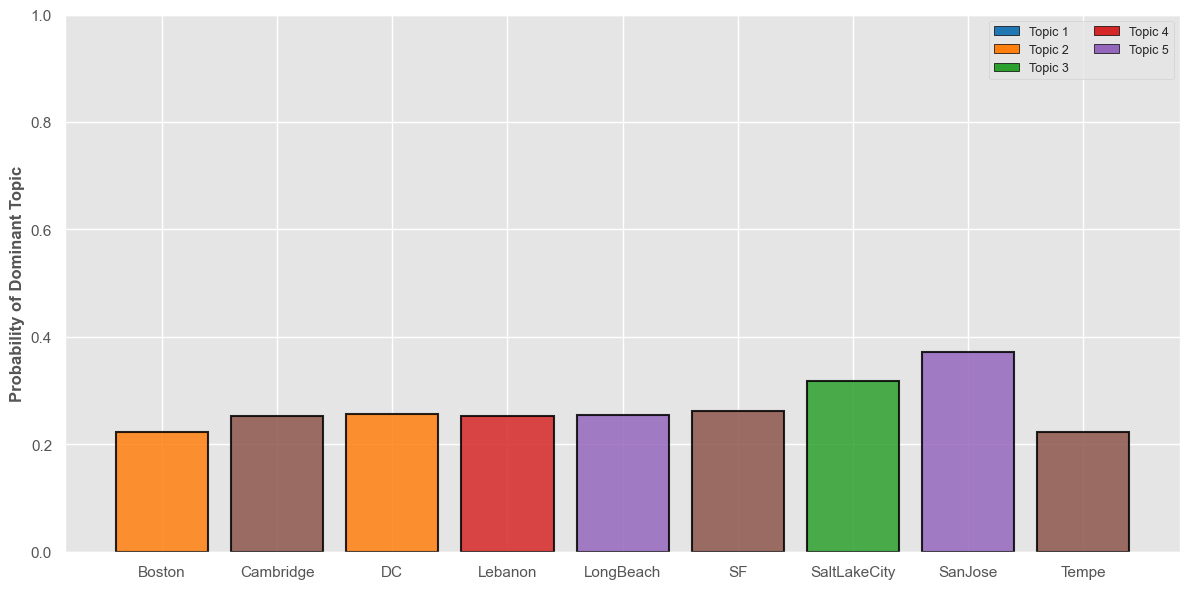


Dominant Topics Summary:
       Document Dominant Topic  Probability
0        Boston        Topic 1        0.224
1     Cambridge        Topic 5        0.253
2            DC        Topic 1        0.257
3       Lebanon        Topic 3        0.252
4     LongBeach        Topic 4        0.255
5            SF        Topic 5        0.262
6  SaltLakeCity        Topic 2        0.317
7       SanJose        Topic 4        0.371
8         Tempe        Topic 5        0.222


In [125]:
# Bar chart showing which topic is most prominent in each document

# Get dominant topic for each document
doc_dominant_topics = doc_topic_agg.idxmax(axis=1)
doc_dominant_probs = doc_topic_agg.max(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

# Use first 6 tab10 colors (blue through brown) and repeat if needed

bars = ax.bar(
    range(len(doc_topic_agg)),
    doc_dominant_probs,
    color=[plt.get_cmap('tab10').colors[int(doc_dominant_topics.str.extract(r'(\d+)')[0].iloc[i])] for i in range(len(doc_topic_agg))],
    edgecolor='black',
    linewidth=1.5,
    alpha=0.85
)

# Add legend for topics
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=plt.get_cmap('tab10').colors[i % 10], edgecolor='black', label=f'Topic {i +1}') 
                   for i in range(optimal_n_topics)]
ax.legend(handles=legend_elements, loc='upper right', ncol=2, fontsize=9)

ax.set_xticks(range(len(doc_topic_agg)))

ax.set_xticklabels(doc_topic_agg.index, rotation=0)

ax.set_ylabel('Probability of Dominant Topic', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('../visualizations/doc_dominant_topics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDominant Topics Summary:")
print(pd.DataFrame({
    'Document': doc_topic_agg.index,
    'Dominant Topic': doc_dominant_topics.values,
    'Probability': doc_dominant_probs.values.round(3)
}))